## Создание вертуального коуча

### Загрузка модели

In [ ]:
import torch
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image

# Загрузка модели
model = keypointrcnn_resnet50_fpn(pretrained=True)

# Перевод в режим инференса
model.eval()

# GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

### Работа с референсов. Визуализация ключевых точек и построение скелета.  

In [ ]:
# Ключевые точки
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [1]:
# Загрузка референсного изображения
from google.colab import files

uploaded = files.upload()

In [ ]:
# Загрузка тестового изображения
uploaded = files.upload()

Saving raning_girl_2.png to raning_girl_2.png


In [ ]:
from PIL import Image
import torchvision.transforms as T

# Путь изображений
image_path_1 = 'raning_girl.png'
image_path_2 = 'raning_girl_2.png'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 886, 1300])
torch.Size([3, 1536, 1024])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

In [ ]:
# Функция для отрисовки ключевых точек
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().cpu().numpy().tolist())
                    )
                    # выбираем цвет
                    color = (0, 0, 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

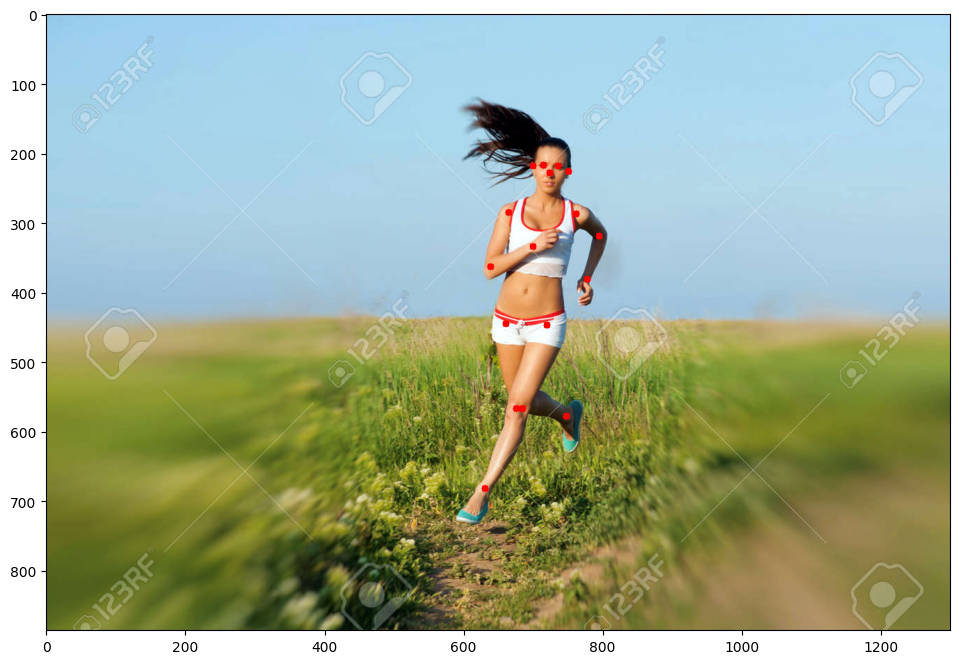

In [ ]:
# Визуализация
img_with_kp = draw_keypoints_per_person(img_1, all_keypoints_1, all_scores_1, confs_1)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()

In [ ]:
# Создание конечностей
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

limbs = get_limbs_from_keypoints(keypoints)

In [ ]:
limbs

[[2, 0],
 [2, 4],
 [1, 0],
 [1, 3],
 [6, 8],
 [8, 10],
 [5, 7],
 [7, 9],
 [12, 14],
 [14, 16],
 [11, 13],
 [13, 15],
 [6, 5],
 [12, 11],
 [6, 12],
 [5, 11]]

In [ ]:
# Функция отрисовки скелета
def draw_skeleton(img, all_keypoints, confs, limbs, conf_threshold=0.9):

    img_copy = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for person_id in range(len(all_keypoints)):
        if confs[person_id] > conf_threshold:
            keypoints_person = all_keypoints[person_id]

            # Рисуем кружки на ключевых точках
            for kp in range(keypoints_person.shape[0]):
                if keypoints_person[kp, 2] > 0:  # проверяем видимость
                    point = tuple(map(int, keypoints_person[kp, :2].detach().cpu().numpy()))
                    cv2.circle(img_copy, point, 5, (0, 0, 255), -1)

            # Рисуем линии (скелет)
            for limb in limbs:
                i, j = limb
                if keypoints_person[i, 2] > 0 and keypoints_person[j, 2] > 0:
                    pt1 = tuple(map(int, keypoints_person[i, :2].detach().cpu().numpy()))
                    pt2 = tuple(map(int, keypoints_person[j, :2].detach().cpu().numpy()))
                    cv2.line(img_copy, pt1, pt2, (0, 0, 255), 2)

    return img_copy

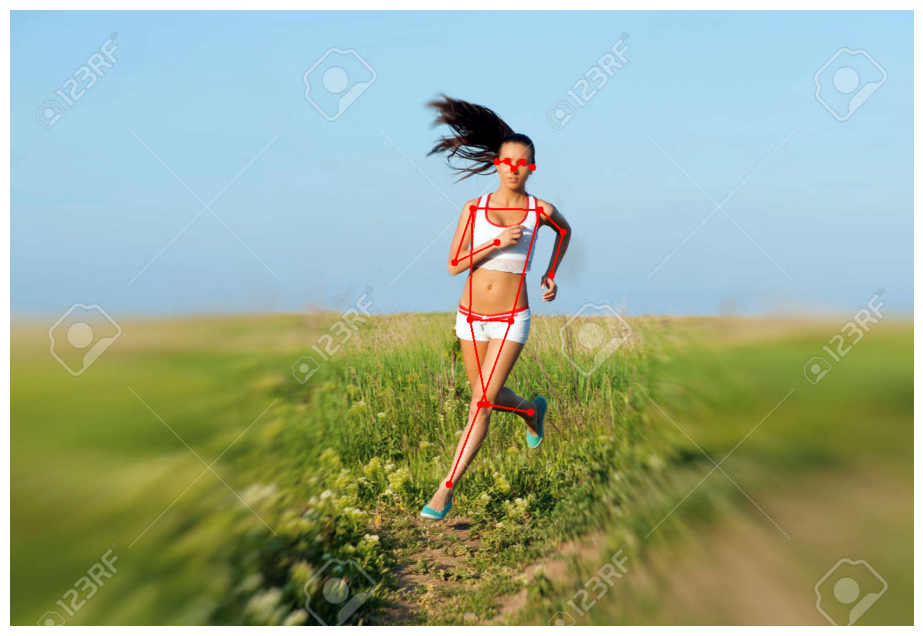

In [ ]:
# Визуализация
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

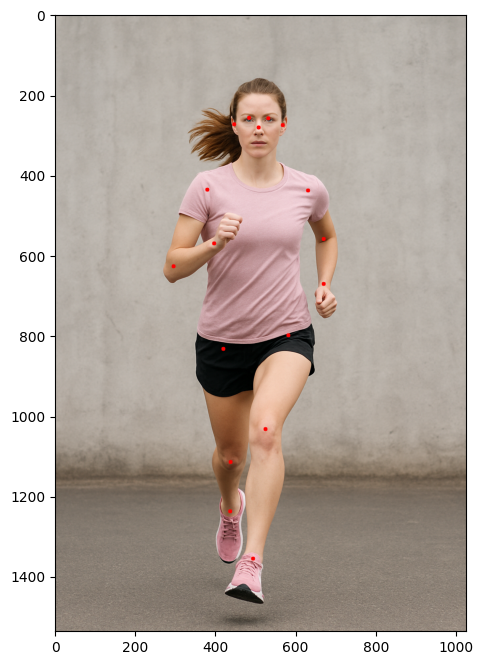

In [ ]:
# Визуализация ключевых точек на тестовом изображении
img_with_kp = draw_keypoints_per_person(img_2, all_keypoints_2, all_scores_2, confs_2)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()

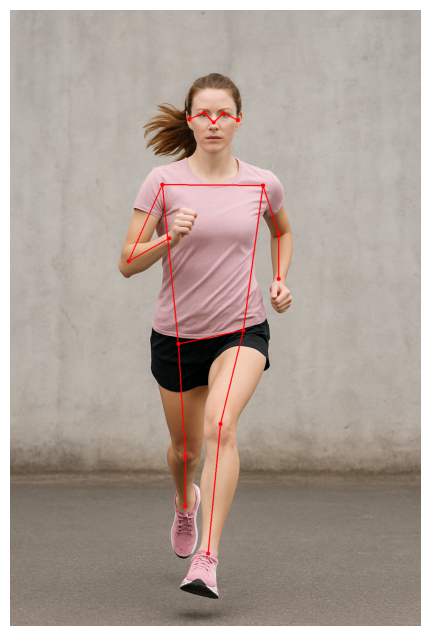

In [ ]:
# Визуализация скелета на тестовом изображении
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Выранивание и сопоставление изображений

In [ ]:
import numpy as np

# Ключевые точки выравнивания
important_joints = [
    'nose','left_eye','right_eye','left_ear','right_ear',
    'left_shoulder','right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip','right_hip',
    'left_knee','right_knee','left_ankle','right_ankle'
    ]

def get_points_from_keypoints(all_keypoints, keypoints_names, target_names, person_id=0):
    person_kp = all_keypoints[person_id].detach().cpu().numpy()
    pts = []
    for name in target_names:
        idx = keypoints_names.index(name)
        pts.append(person_kp[idx, :2])
    return np.array(pts, dtype=np.float32)


model_key_points = get_points_from_keypoints(all_keypoints_1, keypoints, important_joints)
input_key_points = get_points_from_keypoints(all_keypoints_2, keypoints, important_joints)

In [ ]:
# Аффинное отображение

pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

Y = pad(model_key_points)
X = pad(input_key_points)

A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)

A[np.abs(A) < 1e-10] = 0

transform = lambda x: unpad(np.dot(pad(x), A))
input_transformed = transform(input_key_points)

In [ ]:
import math

# Косинусное сходство
def cosine_distance(pose1, pose2):

    pose1 = pose1.flatten()
    pose2 = pose2.flatten()

    cossim = pose1.dot(np.transpose(pose2)) / (
        np.linalg.norm(pose1) * np.linalg.norm(pose2)
    )

    dist = cossim
    return dist


# Взвешенное совпадение
def weight_distance(pose1, pose2, conf1):

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    pose1 = pose1.flatten()
    pose2 = pose2.flatten()

    for i in range(len(pose1)):
        conf_ind = math.floor(i / 2)
        sum2 += conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

In [ ]:
pose1 = model_key_points
pose2 = input_transformed
conf1 = all_scores_1[0].detach().cpu().numpy().flatten()[:len(pose1)]

cos_sim = cosine_distance(pose1, pose2)
w_dist = weight_distance(pose1, pose2, conf1)

In [ ]:
# Функция для отображения скелета
# тестового изображения на референсное изображение
limbs_to_fig = [
    [2, 0], [2, 4], [1, 0], [1, 3], [6, 8], [8, 10], [5, 7], [7, 9],
    [12, 14], [14, 16], [11, 13], [13, 15], [6, 5], [12, 11], [6, 12], [5, 11]
]

def visualize_pose_similarity(img, pose1, pose2, limbs_to_fig, cos_sim, w_dist, title="Сравнение поз"):
    img_copy = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Первая поза
    for limb in limbs_to_fig:
        i, j = limb
        pt1 = tuple(map(int, pose1[i]))
        pt2 = tuple(map(int, pose1[j]))
        cv2.line(img_copy, pt1, pt2, (0, 0, 255), 3)
        cv2.circle(img_copy, pt1, 5, (0, 0, 255), -1)
        cv2.circle(img_copy, pt2, 5, (0, 0, 255), -1)

    # Вторя поза
    for limb in limbs_to_fig:
        i, j = limb
        pt1 = tuple(map(int, pose2[i]))
        pt2 = tuple(map(int, pose2[j]))
        cv2.line(img_copy, pt1, pt2, (0, 255, 0), 3)
        cv2.circle(img_copy, pt1, 5, (0, 255, 0), -1)
        cv2.circle(img_copy, pt2, 5, (0, 255, 0), -1)


    # Визуализация
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

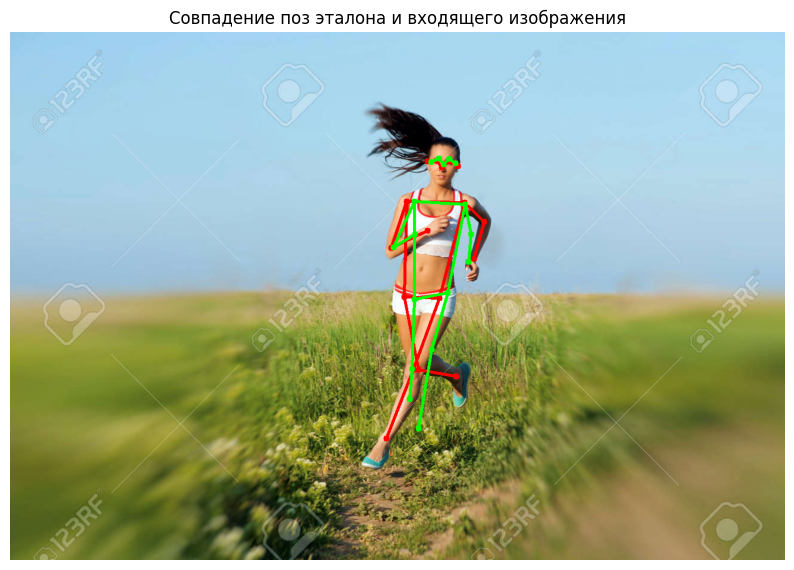

In [ ]:
# Визуализация
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения"
)

### Работа с видио

In [ ]:
# Работа с Видио
# Эталон
from google.colab import files
uploaded = files.upload()


Saving dspr_cv_u1_diploma_spr3_2.mp4 to dspr_cv_u1_diploma_spr3_2.mp4


In [ ]:
# Тест
uploaded = files.upload()

Saving my_dance_15-30-13.mp4 to my_dance_15-30-13.mp4


In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
f_list = []
count = 0
videoFile = "dspr_cv_u1_diploma_spr3_2.mp4"
cap = cv2.VideoCapture(videoFile)  # Загрузка видео
frameRate = cap.get(5)  # Чстота кадров
x = 1

while cap.isOpened():
    frameId = cap.get(1)  # Номер текущего кадра
    ret, frame = cap.read()
    if not ret:
        break
    elif frameId % math.floor(frameRate) == 0:
        filename = f"frame_ref{count}.jpg"
        count += 1
        cv2.imwrite(filename, frame)
        f_list.append(filename)

cap.release()

In [ ]:
f_list

['frame_ref0.jpg',
 'frame_ref1.jpg',
 'frame_ref2.jpg',
 'frame_ref3.jpg',
 'frame_ref4.jpg',
 'frame_ref5.jpg',
 'frame_ref6.jpg',
 'frame_ref7.jpg',
 'frame_ref8.jpg',
 'frame_ref9.jpg',
 'frame_ref10.jpg',
 'frame_ref11.jpg',
 'frame_ref12.jpg',
 'frame_ref13.jpg',
 'frame_ref14.jpg',
 'frame_ref15.jpg',
 'frame_ref16.jpg',
 'frame_ref17.jpg',
 'frame_ref18.jpg',
 'frame_ref19.jpg',
 'frame_ref20.jpg',
 'frame_ref21.jpg']

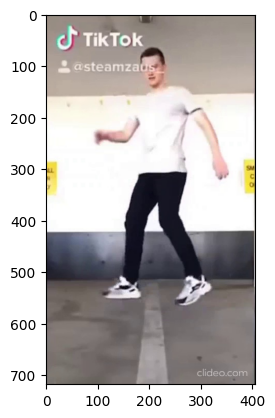

In [ ]:
# Визуализация кадра с реверенсного видео
img = plt.imread('frame_ref11.jpg')
plt.imshow(img)

In [ ]:
# Раскадровка тестового видео
f_list2 = []
count = 0
videoFile = "my_dance_15-30-13.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)
x = 1

while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if not ret:
        break
    elif frameId % math.floor(frameRate) == 0:
        filename = f"frame_i{count}.jpg"
        count += 1
        cv2.imwrite(filename, frame)
        f_list2.append(filename)

cap.release()

In [ ]:
f_list2

['frame_i0.jpg',
 'frame_i1.jpg',
 'frame_i2.jpg',
 'frame_i3.jpg',
 'frame_i4.jpg',
 'frame_i5.jpg']

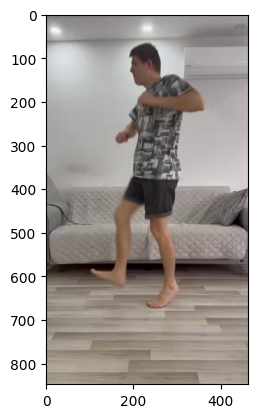

In [ ]:
# Визуализация
img2 = plt.imread('frame_i0.jpg')
plt.imshow(img2)

### Сравнение первого кадра

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Загрузка изображения
image_path_1 = 'frame_ref11.jpg'
image_path_2 = 'frame_i0.jpg'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 718, 406])
torch.Size([3, 848, 464])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

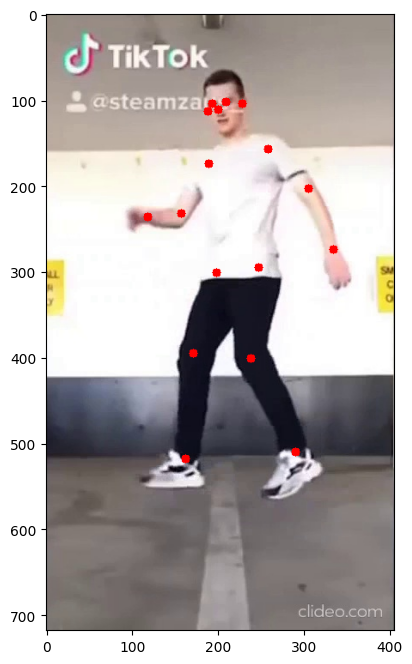

In [ ]:
# Визуализация ключевых точек эталона
img_with_kp = draw_keypoints_per_person(img_1, all_keypoints_1, all_scores_1, confs_1)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()

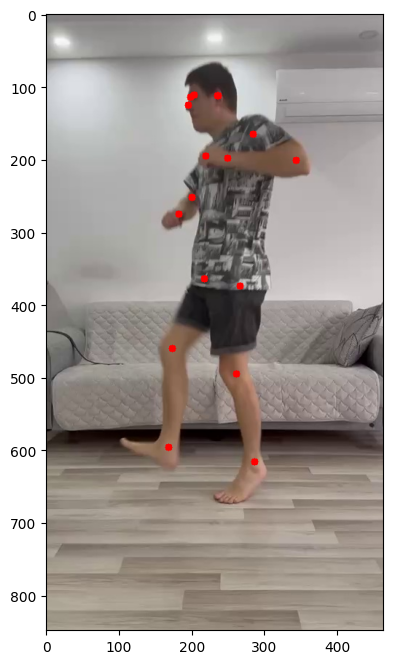

In [ ]:
# Визуализация ключевых точек теста
img_with_kp = draw_keypoints_per_person(img_2, all_keypoints_2, all_scores_2, confs_2)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()

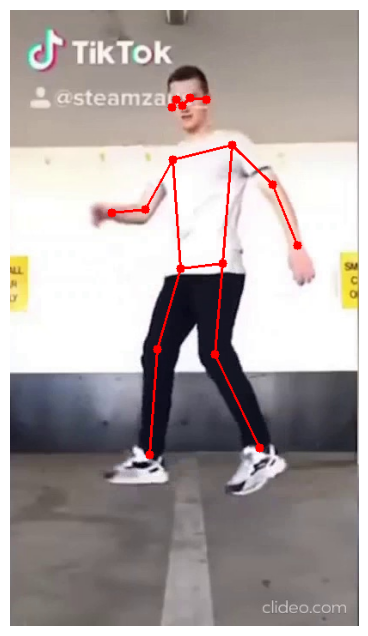

In [ ]:
# Визуализация скелета эталона
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

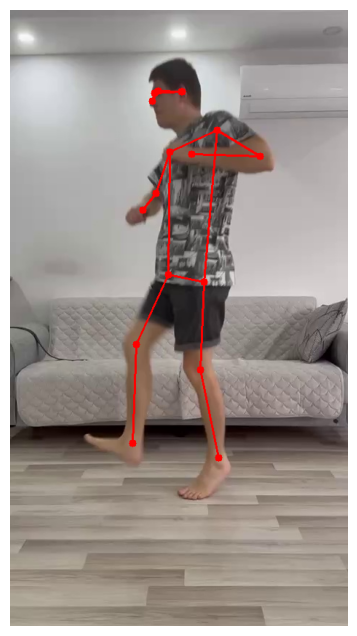

In [ ]:
# Визуализация скелета теста
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

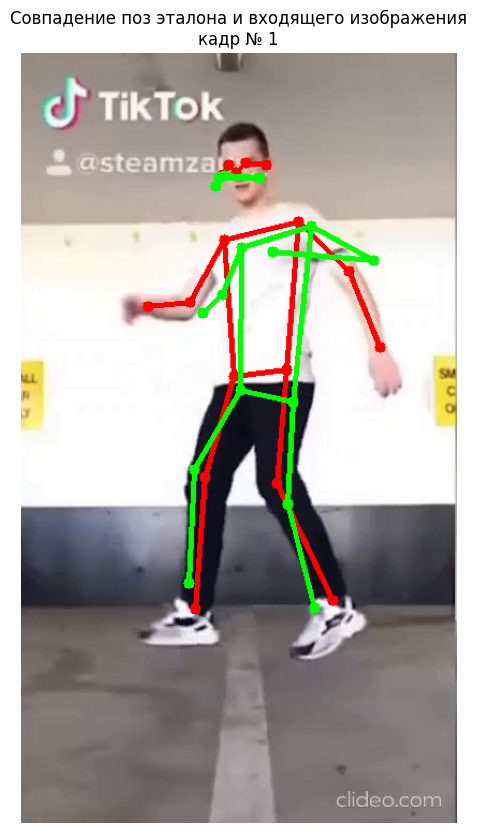

Косинусное сходство: 0.9937
Взвешенная дистанция: 40.4296


In [ ]:
# Визуализация наложения поз
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения\nкадр № 1"
)
print(f"Косинусное сходство: {cos_sim:.4f}")
print(f"Взвешенная дистанция: {w_dist:.4f}")

### Сравнение второго кадра

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Загрузка изображения
image_path_1 = 'frame_ref12.jpg'
image_path_2 = 'frame_i1.jpg'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 718, 406])
torch.Size([3, 848, 464])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

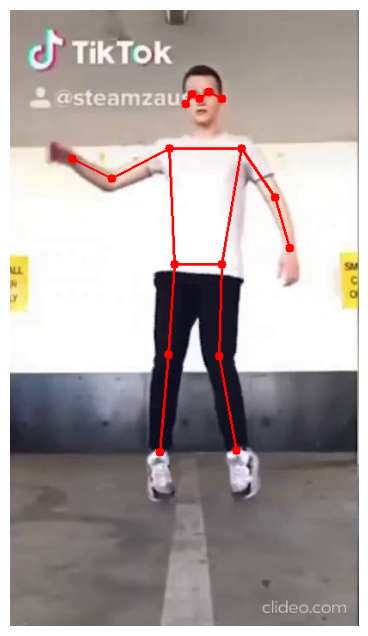

In [ ]:
# Визуализация скелета эталона
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

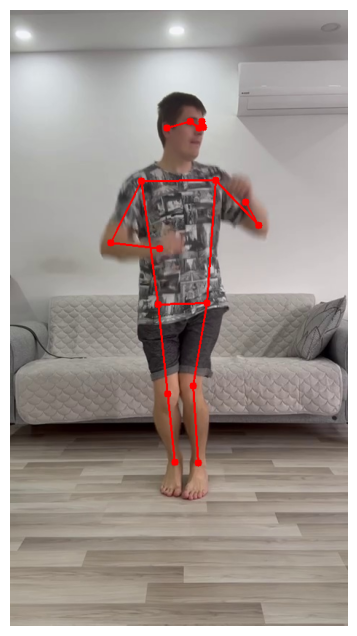

In [ ]:
# Визуализация скелета теста
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

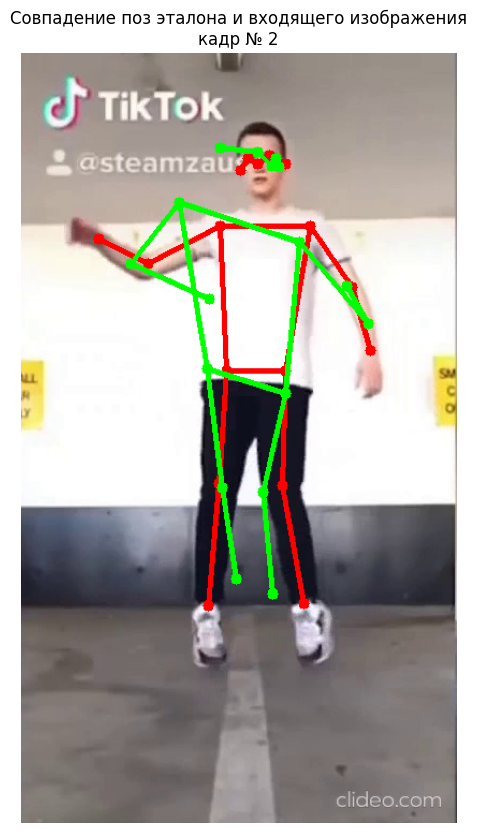

Косинусное сходство: 0.9940
Взвешенная дистанция: 33.3165


In [ ]:
# Визуализация наложения поз
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения\nкадр № 2"
)
print(f"Косинусное сходство: {cos_sim:.4f}")
print(f"Взвешенная дистанция: {w_dist:.4f}")

### Сравнение третьего кадра

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Загрузка изображения
image_path_1 = 'frame_ref13.jpg'
image_path_2 = 'frame_i2.jpg'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 718, 406])
torch.Size([3, 848, 464])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

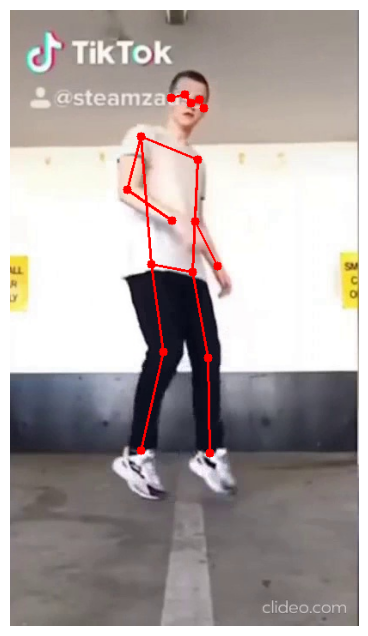

In [ ]:
# Визуализация скелета эталона
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

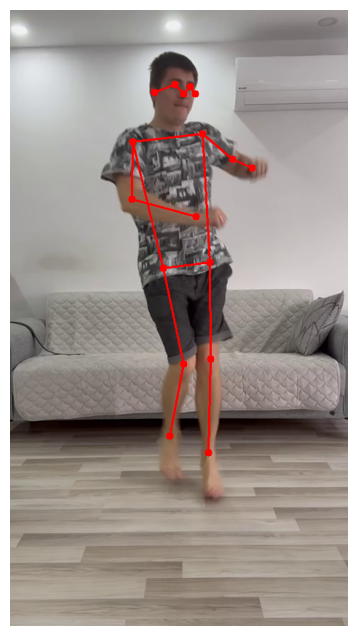

In [ ]:
# Визуализация скелета теста
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# Визуализация наложения поз
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения\nкадр № 3"
)
print(f"Косинусное сходство: {cos_sim:.4f}")
print(f"Взвешенная дистанция: {w_dist:.4f}")

Косинусное сходство: 0.9976
Взвешенная дистанция: 27.7805


### Сравнение четвертого кадра

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Загрузка изображения
image_path_1 = 'frame_ref15.jpg'
image_path_2 = 'frame_i3.jpg'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 718, 406])
torch.Size([3, 848, 464])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

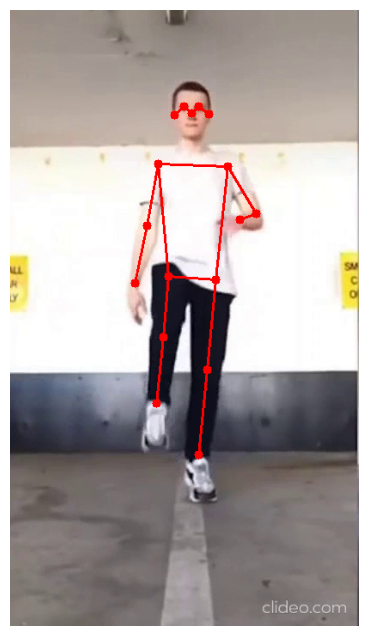

In [ ]:
# Визуализация скелета эталона
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# Визуализация скелета теста
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

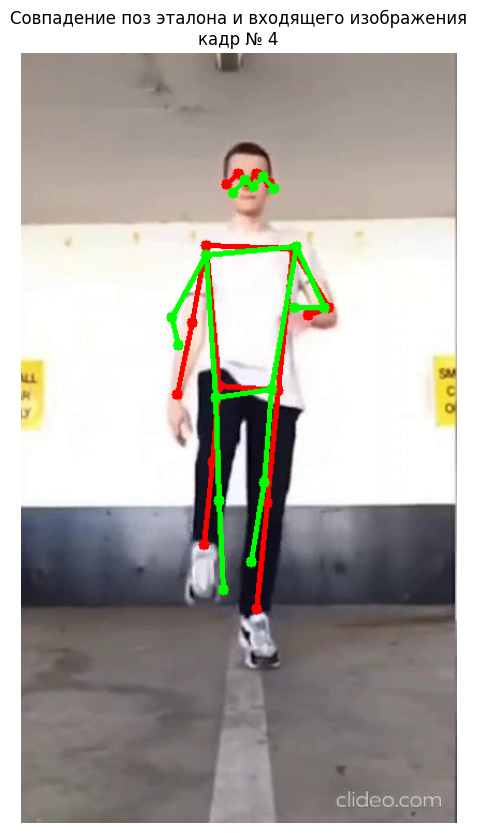

Косинусное сходство: 0.9980
Взвешенная дистанция: 18.6788


In [ ]:
# Визуализация наложения поз
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения\nкадр № 4"
)
print(f"Косинусное сходство: {cos_sim:.4f}")
print(f"Взвешенная дистанция: {w_dist:.4f}")

### Сравнение пятого кадра

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Загрузка изображения
image_path_1 = 'frame_ref17.jpg'
image_path_2 = 'frame_i4.jpg'

img_1 = Image.open(image_path_1).convert("RGB")
img_2 = Image.open(image_path_2).convert("RGB")

# Трансформация
transform = T.Compose([
    T.ToTensor()
])

img_tensor_1 = transform(img_1)
img_tensor_2 = transform(img_2)

# Размер
print(img_tensor_1.shape)
print(img_tensor_2.shape)

torch.Size([3, 718, 406])
torch.Size([3, 848, 464])


In [ ]:
img_tensor_1 = img_tensor_1.to(device)
img_tensor_2 = img_tensor_2.to(device)

# Прогон через модель
with torch.no_grad():
    outputs_1 = model([img_tensor_1])
    outputs_2 = model([img_tensor_2])

all_keypoints_1 = outputs_1[0]['keypoints']
all_scores_1 = outputs_1[0]['keypoints_scores'] if 'keypoints_scores' in outputs_1[0] else outputs_1[0]['scores'].unsqueeze(1)
confs_1 = outputs_1[0]['scores']

all_keypoints_2 = outputs_2[0]['keypoints']
all_scores_2 = outputs_2[0]['keypoints_scores'] if 'keypoints_scores' in outputs_2[0] else outputs_2[0]['scores'].unsqueeze(1)
confs_2 = outputs_2[0]['scores']

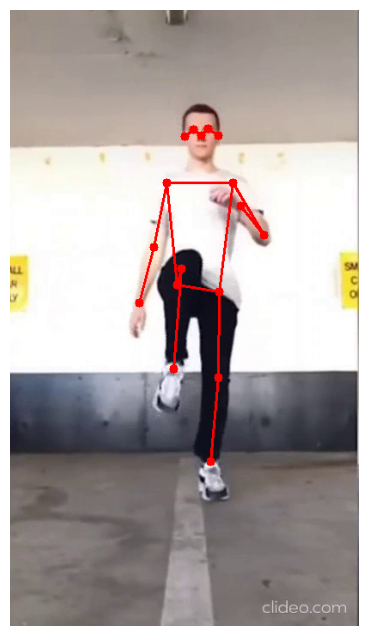

In [ ]:
# Визуализация скелета эталона
img_with_skeleton = draw_skeleton(img_1, all_keypoints_1, confs_1, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

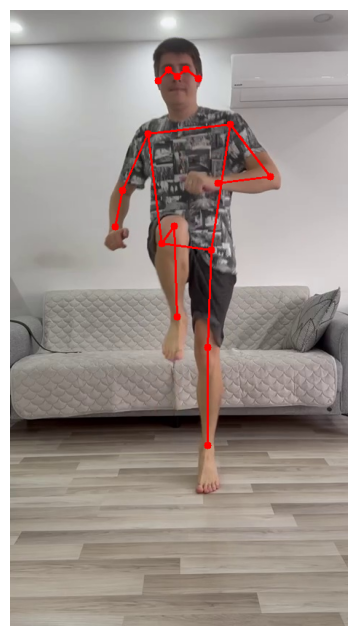

In [ ]:
# Визуализация скелета теста
img_with_skeleton = draw_skeleton(img_2, all_keypoints_2, confs_2, limbs)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_with_skeleton, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

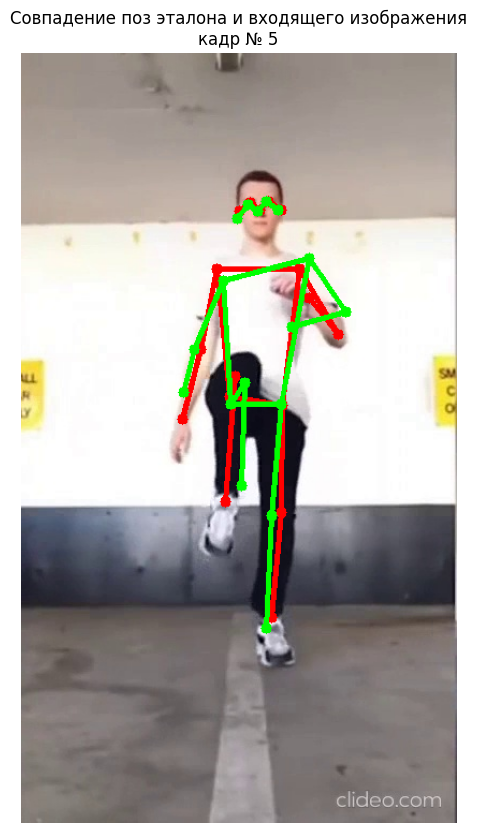

Косинусное сходство: 0.9993
Взвешенная дистанция: 13.6410


In [ ]:
# Визуализация наложения поз
visualize_pose_similarity(
    img_1,
    model_key_points,
    input_transformed,
    limbs_to_fig,
    cos_sim,
    w_dist,
    title="Совпадение поз эталона и входящего изображения\nкадр № 5"
)
print(f"Косинусное сходство: {cos_sim:.4f}")
print(f"Взвешенная дистанция: {w_dist:.4f}")

### Итоговое сравнение

In [ ]:
# Работа с видио
# Эталон
from google.colab import files
uploaded = files.upload()


Saving ref.mp4 to ref (2).mp4


In [ ]:
# Тест
uploaded = files.upload()

Saving i_2.mp4 to i_2 (1).mp4


In [ ]:
import cv2
import torch
import numpy as np
from torchvision.transforms import functional as F
import math
from IPython.display import Video, display
from torchvision.models.detection import keypointrcnn_resnet50_fpn

In [ ]:
# Путь к файлам
reference_video = "ref (2).mp4"
my_video = "i_2 (1).mp4"

In [ ]:
# Ключевые точки и конечности
keypoints = [
    'nose','left_eye','right_eye','left_ear','right_ear',
    'left_shoulder','right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip','right_hip',
    'left_knee','right_knee','left_ankle','right_ankle'
]

limbs = [
    [2,0],[2,4],[1,0],[1,3],
    [6,8],[8,10],[5,7],[7,9],
    [12,14],[14,16],[11,13],[13,15],
    [6,5],[12,11],[6,12],[5,11]
]

In [ ]:
# Функции для предворительной обработки видео
# Извлечение координат ключевых точек
def get_pose(frame, model, device, conf_threshold=0.9):
    img_tensor = F.to_tensor(frame).to(device)
    with torch.no_grad():
        out = model([img_tensor])[0]
    if len(out['keypoints'])>0 and out['scores'][0]>conf_threshold:
        kps = out['keypoints'][0][:,:2].cpu().numpy()
        conf = out['keypoints_scores'][0].cpu().numpy()
        return kps, conf
    else:
        return None, None

# Вычисление косинусного сходства
def cosine_distance(p1,p2):
    p1,p2=p1.flatten(),p2.flatten()
    return p1.dot(p2)/(np.linalg.norm(p1)*np.linalg.norm(p2))

# Вычисление взвешенного расстояния
def weighted_distance(p1,p2,conf):
    p1,p2=p1.flatten(),p2.flatten()
    sum1 = 1/np.sum(conf)
    sum2 = 0
    for i in range(len(p1)):
        idx = math.floor(i/2)
        sum2 += conf[idx]*abs(p1[i]-p2[i])
    return sum1*sum2

# Отрисовка скелета
def draw_pose(frame, pose, color):
    for i,j in limbs:
        if i<len(pose) and j<len(pose):
            pt1, pt2 = tuple(map(int,pose[i])), tuple(map(int,pose[j]))
            cv2.line(frame,pt1,pt2,color,2)
            cv2.circle(frame,pt1,4,color,-1)
            cv2.circle(frame,pt2,4,color,-1)

# Изменение размера с сохранением пропорций
def resize_with_aspect(frame, target_width, target_height):
    h, w = frame.shape[:2]
    scale = min(target_width/w, target_height/h)
    new_w, new_h = int(w*scale), int(h*scale)
    resized = cv2.resize(frame, (new_w, new_h))
    canvas = np.zeros((target_height, target_width,3), dtype=np.uint8)
    x_offset = (target_width - new_w)//2
    y_offset = (target_height - new_h)//2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas


# Обработка видео
width, height = 640,480
ref_cap = cv2.VideoCapture(reference_video)
usr_cap = cv2.VideoCapture(my_video)
fps = int(min(ref_cap.get(cv2.CAP_PROP_FPS), usr_cap.get(cv2.CAP_PROP_FPS)))
out = cv2.VideoWriter('comparison.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width*2,height))

frame_id = 0
while True:
    ret1, ref_frame_orig = ref_cap.read()
    ret2, usr_frame_orig = usr_cap.read()
    if not (ret1 and ret2):
        break

    # Сохранение пропорций
    ref_frame = resize_with_aspect(ref_frame_orig,width,height)
    usr_frame = resize_with_aspect(usr_frame_orig,width,height)

    # Получение ключевых точек из измененных кадров
    ref_pose, ref_conf = get_pose(ref_frame, model, device)
    usr_pose, usr_conf = get_pose(usr_frame, model, device)

    if ref_pose is not None and usr_pose is not None:
        # Вычисление метрик
        cos_sim = cosine_distance(ref_pose, usr_pose)
        w_dist = weighted_distance(ref_pose, usr_pose, ref_conf)

        # Отрисовка скелетов
        draw_pose(ref_frame, ref_pose,(0,0,255))# Эталон
        draw_pose(usr_frame, usr_pose,(0,255,0))# Тест

        # Вывод метрик
        text = f"Cosine: {cos_sim:.3f} | Weighted: {w_dist:.3f}"
        cv2.putText(ref_frame,text,(10,30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0),4)
        cv2.putText(ref_frame,text,(10,30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    # Объединение видео
    combined = np.hstack((ref_frame,usr_frame))
    out.write(combined)

    frame_id += 1
    if frame_id % 10 == 0:
        print(f"Processed frame {frame_id}")

ref_cap.release()
usr_cap.release()
out.release()
print("Видео сохранено: comparison.mp4")

Processed frame 10
Processed frame 20
Processed frame 30
Processed frame 40
Processed frame 50
Processed frame 60
Processed frame 70
Processed frame 80
Processed frame 90
Processed frame 100
Processed frame 110
Processed frame 120
Processed frame 130
Processed frame 140
Processed frame 150
Processed frame 160
Processed frame 170
Processed frame 180
Processed frame 190
Processed frame 200
Processed frame 210
Processed frame 220
Processed frame 230
Processed frame 240
Видео сохранено: comparison.mp4


In [ ]:
# Сохранение видео
files.download("comparison.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>